In [1]:
import numpy as np
import netCDF4 as nc
import scipy.io as sio
from scipy import interpolate
import datetime
import matplotlib.pyplot as plt
import  matplotlib.cm as cm
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/modules/')
import functions_plot

# Notes: NEMO's analytical function

**[Page 57]** In the vertical, the model mesh is determined by four things: (1) the bathymetry given in meters (2) the number of levels of the model (jpk) (3) the analytical transformation z(i, j, k) and the vertical scale factors (4) the masking system (the number of wet model levels at each (i, j) column of points).

**[Page 63]** In z-coordinate partial step (ln zps=.true.), the depths of the model levels are defined by the reference analytical function z0(k), except in the bottom layer. The thickness of the bottom layer is allowed to vary as a function of geographical location (lon, lat) to allow a better representation of the bathymetry.

**[Page 60]** The reference coordinate transformation z0(k) defines the arrays gdept0 and gdepw0 for t- and w-points, respectively. The vertical location of w- and t-levels is defined from the analytic expression of the depth z0(k) whose analytical derivative with respect to k provides the vertical scale factors. 

It is possible to define a simple regular vertical grid by giving zero stretching (ppacr=0). It is often desirable to concentrate the vertical resolution near the ocean surface. The following function is proposed as a standard for
a z-coordinate (with either full or partial steps):

$z_0(k) = h_{sur} - h_0 k - h_1 log [ cosh ((k - h_{th}) / h_{cr})]$

With $h_{cr}$ and jpk, the four parameters (h...) have been determined such that these are satisfied, through an optimisation procedure using a bisection method.
$e_3(1 + 1/2) = 10$ and $e_3(jpk - 1/2) = 500$ and $z(1) = 0$ and $z(jpk) = -500$

Rather than entering the parameters (h...) directly, set ppsur=ppa0=ppa1=999999 in namcfg and specify the following:
* ppacr=hcr : stretching factor 
* ppkth=hth : level at which maximum stretching
* ppdzmin : top layer minimum thickness
* pphmax : total depth of the ocean

**[Page 63]** With partial steps, layers from 1 to jpk-2 can have a thickness smaller than e3t(jk). The model deepest layer (jpk-1) is allowed to have either a smaller or larger thickness than e3t(jpk): the maximum thickness allowed is 2 * e3t(jpk -1)

Two variables in the namdom namelist are used to define the partial step vertical grid. The mimimum water thickness (in meters) allowed for a cell partially filled with bathymetry at level jk is the minimum of rn_e3zps_min (thickness in meters, usually 20 m) or e3t(jk) * rn_e3zps_rat (a fraction, usually 10%, of the default thickness e3t(jk)).


* phy_cst : initialization of ocean parameters and constants
* dom_nam  : domain initialization through namelist read (Namelist namdom : space & time domain)   
* zgr_z   : Reference vertical z-coordinates
* dta_tsd_init : Temperature & Salinity data 

[PrepareTS.ipynb](http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/tools/raw/tip/I_ForcingFiles/Initial/PrepareTS.ipynb)

# Observations
The salinity and temperature measurements were obtained from M. Chanona. There are 34 profiles. The shallow set has 21 profiles and the deep set has 13 profiles. The shallow set goes to 257 m depth, while the deep goes to 2046 m. In order to look at the data more easily, I joined both sets.

In [2]:
# Load two datasets
ts_data_shal = sio.loadmat('canyonTSdata.mat')
ts_data_deep = sio.loadmat('canyonTSdata2.mat')

# Extract important variables
longitudes = np.concatenate((ts_data_shal['loncanyon'][0], ts_data_deep['loncanyon2'][0]),axis=0)
latitudes = np.concatenate((ts_data_shal['latcanyon'][0], ts_data_deep['latcanyon2'][0]),axis=0)
years = np.concatenate((ts_data_shal['yrcanyon'][0], ts_data_deep['yrcanyon2'][0]),axis=0)
days = np.concatenate((ts_data_shal['daycanyon'][0], ts_data_deep['daycanyon2'][0]),axis=0)
con_temps = np.concatenate((ts_data_shal['tempcanyon'], ts_data_deep['tempcanyon2']),axis=1)
abs_salts = np.concatenate((ts_data_shal['salcanyon'], ts_data_deep['salcanyon2']),axis=1)
depths = np.concatenate((ts_data_shal['depthcanyon'], ts_data_deep['depthcanyon2']),axis=1) * -1

# Dates these measurements were taken
dates = []
for i in range(len(days)):
    date = (datetime.datetime(years[i], 1, 1) + datetime.timedelta(days[i] - 1)).strftime('%b %y')
    dates.append(date)

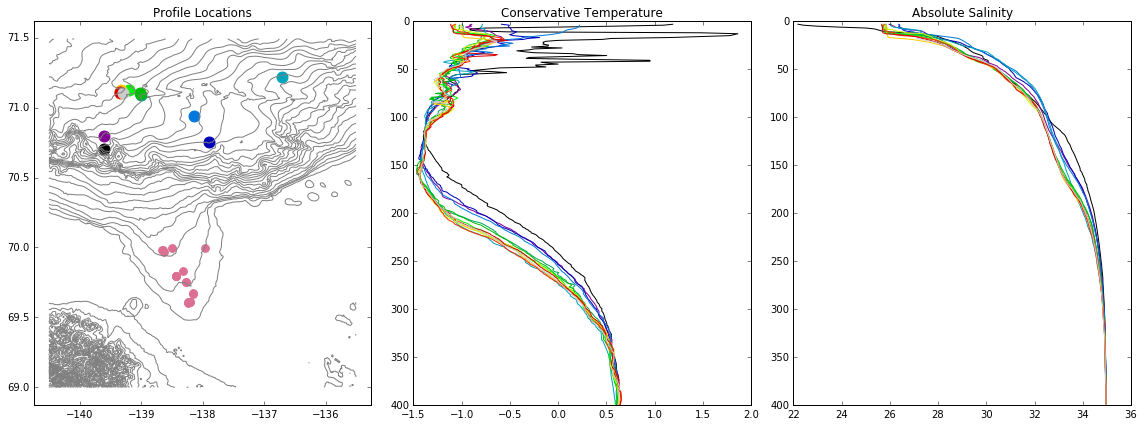

In [59]:
xg, yg, zg = functions_plot.get_variables('G')
xn, yn, zn = functions_plot.def_regionG(-140.5, -135.5, 69.0, 71.5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))
ct = ax1.contour(xn, yn, zn, 60, colors='grey', linestyles='solid')

profiles = np.arange(21,34)
c = cm.nipy_spectral(np.linspace(0, 1, len(profiles)))
for ind, n in zip(profiles, np.arange(len(profiles))):
    ax1.scatter(longitudes[ind], latitudes[ind], color=c[n], s=120)
    ax2.plot(con_temps[:, ind], depths[:, ind], color=c[n])
    ax3.plot(abs_salts[:, ind], depths[:, ind], color=c[n])
    
#ax2.plot(con_temps[:, 21], depths[:, 21], color = 'm')
#ax3.plot(abs_salts[:, 21], depths[:, 21], color = 'm')

profiles = np.arange(21)
for ind in zip(profiles):
    ax1.scatter(longitudes[ind], latitudes[ind], color='palevioletred', s=60)
    
ax2.set_ylim([400,0]); ax3.set_ylim([400,0])
ax1.set_title('Profile Locations')
ax2.set_title('Conservative Temperature')
ax3.set_title('Absolute Salinity')
plt.tight_layout()
plt.show()

# Stratification functions

Any extrapolation beyond where there is information will use the last value in the data profile, as specified by the bounds_error and fill_value arguments. The model_bathy is only used to construct the shape of the stratification field. The profiles will not depend on the actual bathymetry.

In [4]:
def interpolate_votemper(interp_ctemp, data_temp, vertical_spacing, model_bathy):
    ''' This function interpolates the conservative temperature to the depths
    specified in the vertical spacing. 
    
    :arg interp_ctemp: interpolation function
    :arg data_temp: conservative temperature data
    :arg vertical_spacing: depth steps 
    :arg model_bathy: domain bathymetry
    '''
    votemper = np.zeros((1, len(vertical_spacing), model_bathy.shape[0], model_bathy.shape[1]))
    votemper[0,0,:,:] = data_temp[0]

    for id in range(1, len(vertical_spacing)):
        for x in range(0, model_bathy.shape[1]):
            for y in range(0, model_bathy.shape[0]):
                votemper[0, id, y, x] = interp_ctemp(vertical_spacing[id])
    return votemper

def interpolate_vosaline(interp_asalt, data_salt, vertical_spacing, model_bathy):
    ''' This function interpolates the absolute salinity to the depths
    specified in the vertical spacing. 
    
    :arg interp_asalt: interpolation function
    :arg data_salt: absolute salinity data
    :arg vertical_spacing: depth steps 
    :arg model_bathy: domain bathymetry
    '''
    vosaline = np.zeros((1, len(vertical_spacing), model_bathy.shape[0], model_bathy.shape[1]))
    vosaline[0,0,:,:] = data_salt[0]

    for id in range(1, len(vertical_spacing)):
        for x in range(0, model_bathy.shape[1]):
            for y in range(0, model_bathy.shape[0]):
                vosaline[0, id, y, x] = interp_asalt(vertical_spacing[id])
    return vosaline

The profile number is specified and the corresponding depth, temperature, and salinity profiles are extracted and used in calling the interpolation functions. The nans are excluded from the profiles by cutting the profile at the last non-nan depth. Then, when the interpolation functions are called, the fill_value used to extend the stratification profile to the desired depth is defined as the last non-nan depth. Additionally, the interp1d function requires all values to be real. However, sometimes there will be nans at the surface. The full_nans function takes care of this by linearly interpolating with the neighbouring value. This had to be done because the interp1d fill_value only applies to regions out of the range of depths. 

In [5]:
def fill_nans(data):
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

In [6]:
def prepare_profile(profile_number, depths, con_temps, abs_salts):
   
    full_depth = depths[:, profile_number]
    ind_end = np.where(full_depth == np.nanmax(full_depth))[0][0]
    prof_depth = full_depth[:ind_end+1]

    full_ctemp = con_temps[:, profile_number]
    prof_ctemp = full_ctemp[:ind_end+1]

    full_asalt = abs_salts[:, profile_number]
    prof_asalt = full_asalt[:ind_end+1]
    
    prof_depth = fill_nans(prof_depth)
    prof_ctemp = fill_nans(prof_ctemp)
    prof_asalt = fill_nans(prof_asalt)
    
    return prof_depth, prof_ctemp, prof_asalt

In [7]:
def prepare_interpolation(prof_depth, prof_ctemp, prof_asalt):

    interp_ctemp = interpolate.interp1d(prof_depth, prof_ctemp, kind='cubic', 
                                    bounds_error=False, fill_value=prof_ctemp[-1], assume_sorted=False)
    interp_asalt = interpolate.interp1d(prof_depth, prof_asalt, kind='cubic', 
                                    bounds_error=False, fill_value=prof_asalt[-1], assume_sorted=False)
    
    return interp_ctemp, interp_asalt

In [8]:
def generate_interpolation(interp_ctemp, interp_asalt, prof_ctemp, prof_asalt, vertical_spacing, model_bathy):
    
    strat_votemper = interpolate_votemper(interp_ctemp, prof_ctemp, vertical_spacing, model_bathy)
    strat_vosaline = interpolate_vosaline(interp_asalt, prof_asalt, vertical_spacing, model_bathy)
    
    return strat_votemper, strat_vosaline

In [9]:
def full_stratification(profile_number, depths, con_temps, abs_salts):
    
    prof_depth, prof_ctemp, prof_asalt = prepare_profile(profile_number, depths, con_temps, abs_salts)
    interp_ctemp, interp_asalt = prepare_interpolation(prof_depth, prof_ctemp, prof_asalt)
    strat_votemper, strat_vosaline = generate_interpolation(interp_ctemp, interp_asalt, prof_ctemp, prof_asalt, 
                                                            vertical_spacing, model_bathy)
    
    return strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt

In [10]:
def plot_interpolations(strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt,
                        vertical_spacing, model_bathy):

    xs, ys = 58, 58; c = 'dodgerblue'
    fig, (ax2, ax3, ax4) = plt.subplots(1,3,figsize=(14,6)); fig.tight_layout()

    ax2.plot(vertical_spacing, c = 'forestgreen', lw = 2, marker = 'o', linestyle = '-')
    ax2.set_title('depths ' + str(vertical_spacing.shape))
    ax2.set_ylim(prof_depth[-1], 0)

    ax3.plot(prof_ctemp, prof_depth, c = 'gray', lw=2, marker ='o', linestyle='-', label='data', alpha=0.4)
    ax3.plot(strat_votemper[0, :, ys, xs], vertical_spacing, c=c, lw=2, marker ='o', linestyle='-', label='interp')
    ax3.set_title('temperature ' + str(prof_ctemp.shape) + ' ' + str(strat_votemper.shape))
    ax3.legend(loc=4); ax3.set_ylim(prof_depth[-1], 0)

    ax4.plot(prof_asalt, prof_depth, c = 'gray', lw=2, marker ='o', linestyle='-', label='data', alpha=0.4)
    ax4.plot(strat_vosaline[0, :, ys, xs], vertical_spacing, c=c, lw=2, marker ='o', linestyle='-', label='interp')
    ax4.set_title('salinity ' + str(prof_asalt.shape) + ' ' + str(strat_vosaline.shape))
    ax4.legend(loc=3); ax4.set_ylim(prof_depth[-1], 0)

    plt.show()

    return fig

# Creating interpolated profiles

The mesh mask is loaded to obtain the depth profile calculated by nemo, as opposed to deriving it from its analytical formulation. The bathymetry file is used strictly to obtain the shape of the domain in use. The files salinity_01.nc and temperature_01.nc used profile 21.

In [11]:
path_bath = 'idealized/ideal_bathy_03.nc'
path_mesh = 'runs_idealized/Run01/mesh_mask.nc'

file_bath = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/initial_sets/' + path_bath)
file_mesh = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/gyre_mackenzie02/EXP00/' + path_mesh)

model_bathy = file_bath['Bathymetry'][:]
vertical_spacing = file_mesh['gdept_1d'][:][0]

In [14]:
profile_number = 21
strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt = full_stratification(profile_number, 
                                                                                         depths, con_temps, abs_salts)

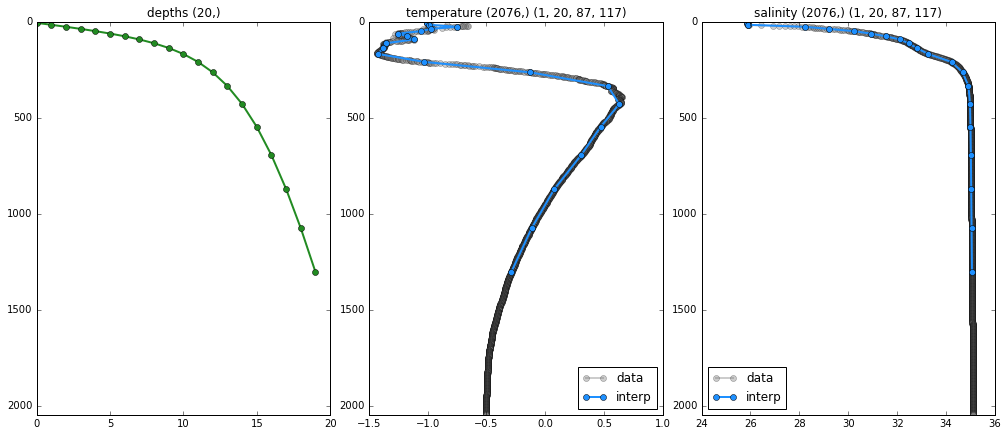

In [13]:
fig = plot_interpolations(strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt,
                        vertical_spacing, model_bathy)

# Save netcdf file

# Individual profiles

In [77]:
profiles = np.arange(21,34)
indices = np.arange(len(profiles))

all_votempers = np.zeros([vertical_spacing.shape[0], len(profiles)])
all_vosalines = np.zeros([vertical_spacing.shape[0], len(profiles)])

for profile_number, ind in zip(profiles, indices):
    strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt = full_stratification(profile_number, 
                                                                                         depths, con_temps, abs_salts)
    all_votempers[:,ind] = strat_votemper[0,:,58,58]
    all_vosalines[:,ind] = strat_vosaline[0,:,58,58]

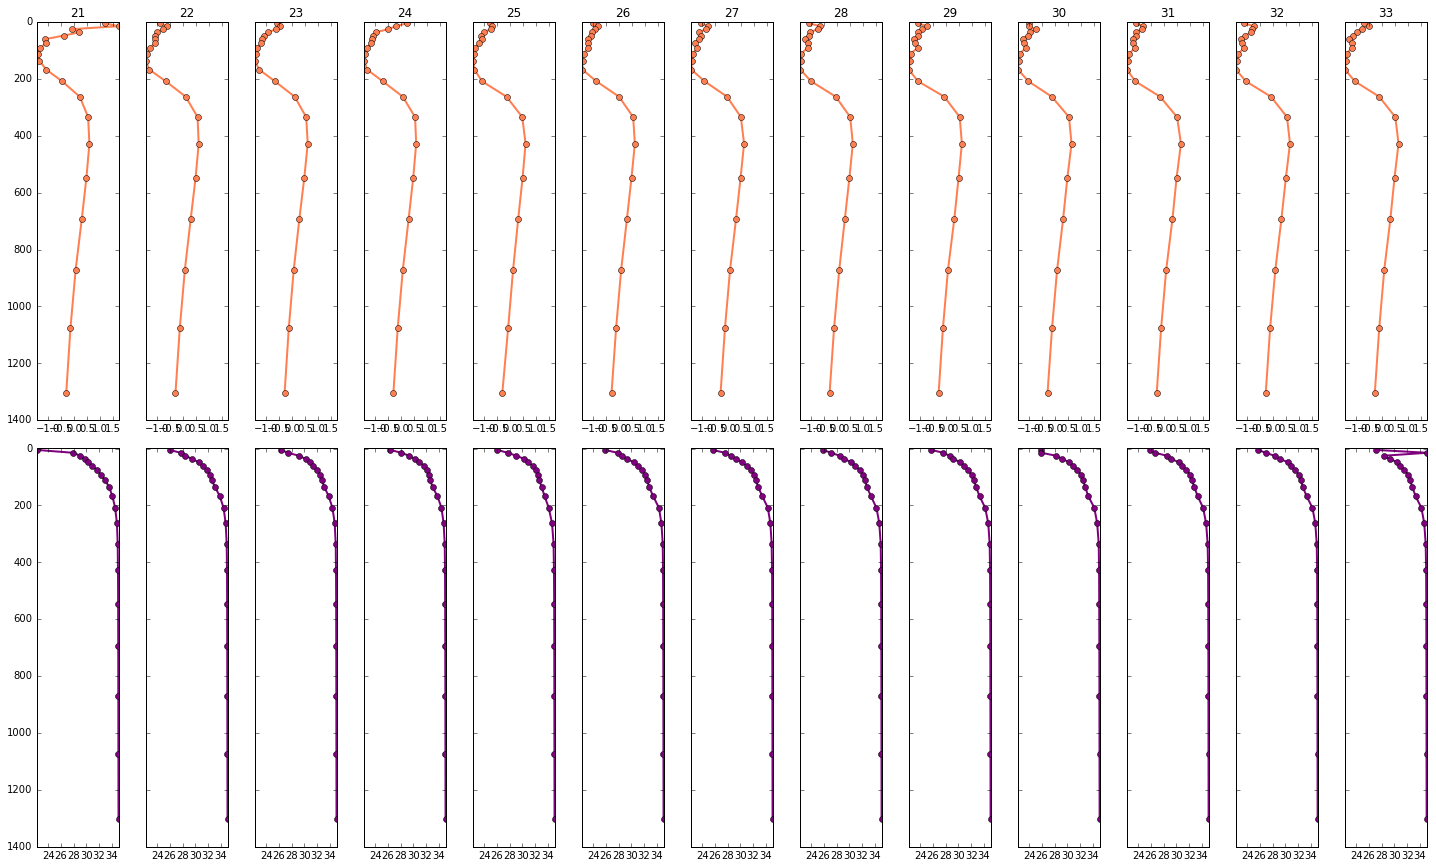

In [114]:
fig, axes = plt.subplots(2, 13, figsize=(20,12), sharey=True)
fig.tight_layout()
for n in range(len(profiles)):
    axes[0, n].plot(all_votempers[:, n], vertical_spacing, c='coral', lw=2, marker ='o', linestyle='-')
    axes[1, n].plot(all_vosalines[:, n], vertical_spacing, c='purple', lw=2, marker ='o', linestyle='-')
    axes[0, n].invert_yaxis()
    axes[0, n].set_xlim(round(all_votempers.min(), 2), round(all_votempers.max(), 2))
    axes[0, n].set_title(str(profiles[n]))
    axes[1, n].set_xlim(round(all_vosalines.min(), 2), round(all_vosalines.max(), 2))


# Calculating N at shelf break